# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [165]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)

        self.value = None
        self.gradients = {}

    
    def forward(self):
        raise NotImplemented
    

    def backward(self):
        raise NotImplemented
        
        
class Input(Node):
    
    def __init__(self):
        Node.__init__(self)

        
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
            

class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        
        
        
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
        
        
    def backward(self):

        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)


            
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  
            self.gradients[self.inputs[0]] = grad_cost * self.partial
            

            
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()

    for n in graph[::-1]:
        n.backward()


        
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]
            

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]


In [166]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

In [167]:
# Load data
losses = []
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000

m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))


for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        
        X.value = X_batch
        y.value = y_batch
        
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)
        

Total number of examples = 506
Epoch: 1, Loss: 191.746
Epoch: 101, Loss: 8.554
Epoch: 201, Loss: 6.823
Epoch: 301, Loss: 5.482
Epoch: 401, Loss: 4.559
Epoch: 501, Loss: 5.523
Epoch: 601, Loss: 4.790
Epoch: 701, Loss: 4.809
Epoch: 801, Loss: 5.007
Epoch: 901, Loss: 4.481
Epoch: 1001, Loss: 3.742
Epoch: 1101, Loss: 4.568
Epoch: 1201, Loss: 4.213
Epoch: 1301, Loss: 3.899
Epoch: 1401, Loss: 4.644
Epoch: 1501, Loss: 4.318
Epoch: 1601, Loss: 4.014
Epoch: 1701, Loss: 4.138
Epoch: 1801, Loss: 3.749
Epoch: 1901, Loss: 3.513
Epoch: 2001, Loss: 3.647
Epoch: 2101, Loss: 3.619
Epoch: 2201, Loss: 4.223
Epoch: 2301, Loss: 4.188
Epoch: 2401, Loss: 3.486
Epoch: 2501, Loss: 3.526
Epoch: 2601, Loss: 4.349
Epoch: 2701, Loss: 3.535
Epoch: 2801, Loss: 4.240
Epoch: 2901, Loss: 3.879
Epoch: 3001, Loss: 3.878
Epoch: 3101, Loss: 3.539
Epoch: 3201, Loss: 3.838
Epoch: 3301, Loss: 3.663
Epoch: 3401, Loss: 3.859
Epoch: 3501, Loss: 3.571
Epoch: 3601, Loss: 3.853
Epoch: 3701, Loss: 3.638
Epoch: 3801, Loss: 3.379
Epoc

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

一个神经元计算激活函数(z = wx+b --线性函数)

####  2. Why we use non-linear activation funcitons in neural networks?

如果激活函数还是线性函数, 基本上一个神经元所计算的都是一些线性关系, 那么对于非线性关系神经元都计算不了。

#### 3. What is the 'Logistic Loss' ?

逻辑损失是针对二分类问题的损失函数, 是交叉熵损失函数的一个特例。

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C

#### 5. Why we don't use zero initialization for all parameters ?

容易造成神经元对称情况, 即使有更多的神经元其发挥的效果也是没有用的。

#### 6. Can you implement the softmax function using python ? 

能, 已在作业的Challege部分已经实现, 函数名字为softmax, 这里不重复粘贴了。

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [67]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [68]:
# Loading the data 
digits = datasets.load_digits()

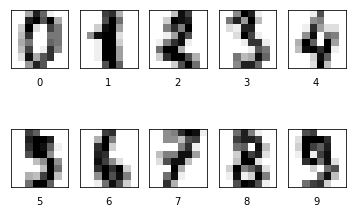

In [69]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [70]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [71]:
X_train.shape, X_train[0].shape

((1347, 64), (64,))

In [72]:
y_train.shape

(1347,)

In [73]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [74]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](network.png)

In [4]:
!pwd

/Users/limingxiao/Desktop/NLP_Lectures/jupyters_and_slides/2019-spring


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [75]:
import numpy as np

def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1. / (1 + np.exp(-1 * z))
    
    return s

In [76]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [77]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    w = np.random.randn(dim,1)
    b = np.random.randn(1).squeeze().tolist()
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [78]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[0]   ###这里应该把原来的X.shape[1] 改为X.shape[0] 因为这里m表示的是样本量
    A = sigmoid(np.dot(X, w) + b)
    Y = Y.reshape((-1,1))
    cost = (-1./ m) * np.sum(Y.T.dot(np.log(A.clip(min=0.0000000001))) + (1-Y).T.dot(np.log((1-A).clip(min=0.0000000001))))

    dw = (1./m)*np.dot(X.T , (A-Y)) 
    db = (1./m)*np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [79]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w -= learning_rate * dw
        b -= learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs


###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [80]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]   ###这里应该把原来的X.shape[1] 改为X.shape[0]  X的形状是(1347, 64)，其中1347才是代表样本量，因为这里m表示的是样本量
    Y_prediction = np.zeros((m,1))   #####Y_prediction = np.zeros((1,m))改为Y_prediction = np.zeros((m,1)) 与 Y的形状保持一致
    w = w.reshape(X.shape[1],1)   # w所对应的应该是X.shape[1] == 64, 
    
    A = sigmoid(np.dot(X, w) + b)
    #for i in range(A.shape[i]):
        #None    
    ####有更高效的方法替代！！！！
    Y_prediction = np.where(A > 0.5, 1, 0)   #不会直接替代
    
    assert(Y_prediction.shape == (m,1))    #assert(Y_prediction.shape == (1,m))改为assert(Y_prediction.shape == (m, 1))
     
    return Y_prediction


##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [81]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost = False):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    w, b = initialize_parameters(X_train.shape[1])
    
    # grads, cost = propagate(w,b,X_train,Y_train)
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    Y_prediction_train = predict(params['w'], params['b'], X_train)
    Y_prediction_train = Y_prediction_train.astype('int')
    Y_train = Y_train.reshape((-1,1))
    training_accuracy = np.sum(Y_train == Y_prediction_train) / Y_train.shape[0]    

    Y_prediction_test = predict(params['w'], params['b'], X_test)
    Y_prediction_test = Y_prediction_test.astype('int')
    Y_test = Y_test.reshape((-1,1))
    test_accuracy = np.sum(Y_test == Y_prediction_test) / Y_test.shape[0]    
    
    d = {"w":params['w'],
         "b":params['b'],
         "training_accuracy": training_accuracy,
         "test_accuracy" : test_accuracy,
         "cost": costs }
    
    return d
    

In [85]:
model(X_train, y_train, X_test, y_test, num_iterations = 100, learning_rate = 1e-2, print_cost = True)

Cost after iteration 0: 11.111365


{'w': array([[-0.49039847],
        [-0.08704381],
        [-0.24263515],
        [-1.65490406],
        [ 1.8290742 ],
        [-1.58933118],
        [ 0.95999134],
        [-0.44182118],
        [ 0.91645021],
        [-0.84798276],
        [ 1.16666388],
        [-1.43481665],
        [-2.00647959],
        [ 1.72500645],
        [ 0.40243891],
        [-0.56870759],
        [-0.27904956],
        [-0.66987757],
        [-0.32123359],
        [-0.42471471],
        [ 0.32953742],
        [-0.79264562],
        [ 0.02856436],
        [ 0.91672984],
        [-0.89858338],
        [ 2.44301328],
        [-0.96555807],
        [ 1.88182042],
        [-0.24327128],
        [ 0.70040191],
        [-1.72879011],
        [-1.66805058],
        [ 0.72198704],
        [-0.67782101],
        [ 1.57785284],
        [ 0.63801173],
        [-0.7482349 ],
        [-0.66935811],
        [ 1.34010383],
        [ 0.93094454],
        [ 2.14410859],
        [-0.17410695],
        [-0.52664067],
      

In [86]:
model(X_train, y_train, X_test, y_test, num_iterations = 1000, learning_rate = 1e-2, print_cost = True)

Cost after iteration 0: 11.483466
Cost after iteration 100: 2.543536
Cost after iteration 200: 1.636144
Cost after iteration 300: 1.240194
Cost after iteration 400: 1.030191
Cost after iteration 500: 0.889590
Cost after iteration 600: 0.791352
Cost after iteration 700: 0.720655
Cost after iteration 800: 0.666419
Cost after iteration 900: 0.622282


{'w': array([[-1.83716066e+00],
        [ 2.11148409e-01],
        [-2.49187818e-01],
        [-2.42342518e-01],
        [ 2.99603904e-01],
        [ 4.01911878e-01],
        [ 4.50731243e-01],
        [ 1.26401951e+00],
        [-7.92523694e-01],
        [-9.97085285e-01],
        [ 5.28146837e-01],
        [ 3.27907634e-01],
        [-1.45098310e-01],
        [ 4.21070193e-02],
        [-3.60806779e-01],
        [-6.14198801e-01],
        [-1.59628834e+00],
        [ 3.47834301e-01],
        [ 4.30637855e-01],
        [ 7.39431310e-02],
        [-7.31793340e-01],
        [-3.15034891e-01],
        [-5.55002846e-03],
        [ 8.32773334e-01],
        [-4.47420803e-01],
        [-3.51895656e-01],
        [-1.13165649e-01],
        [ 6.82572607e-01],
        [ 1.24200184e-03],
        [ 7.27794353e-01],
        [-7.93473906e-01],
        [-9.25494760e-01],
        [-2.92834030e-01],
        [ 1.61707369e-01],
        [-1.38591333e-01],
        [ 5.11403414e-01],
        [-2.07315920e-0

In [87]:
model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.1, print_cost = True)

Cost after iteration 0: 7.715314
Cost after iteration 100: 1.541373
Cost after iteration 200: 4.927333
Cost after iteration 300: 1.085975
Cost after iteration 400: 4.727152
Cost after iteration 500: 1.118505
Cost after iteration 600: 1.602124
Cost after iteration 700: 1.145221
Cost after iteration 800: 1.285268
Cost after iteration 900: 2.147115
Cost after iteration 1000: 1.087222
Cost after iteration 1100: 1.470669
Cost after iteration 1200: 1.398802
Cost after iteration 1300: 1.086335
Cost after iteration 1400: 1.401843
Cost after iteration 1500: 4.109832
Cost after iteration 1600: 1.091976
Cost after iteration 1700: 1.338480
Cost after iteration 1800: 6.713255
Cost after iteration 1900: 1.101891
Cost after iteration 2000: 1.270417
Cost after iteration 2100: 5.107906
Cost after iteration 2200: 1.116210
Cost after iteration 2300: 1.194325
Cost after iteration 2400: 2.265881
Cost after iteration 2500: 1.137077
Cost after iteration 2600: 1.120889
Cost after iteration 2700: 1.569017
Cost

{'w': array([[-1.60365584],
        [ 1.71771346],
        [ 0.26700866],
        [-0.08203271],
        [ 0.6850848 ],
        [ 1.36608568],
        [ 1.22425941],
        [-1.5820396 ],
        [ 0.92142198],
        [-2.1463772 ],
        [ 1.32472202],
        [ 0.52205868],
        [-0.51859545],
        [-0.52854681],
        [ 0.49026471],
        [ 1.90515719],
        [ 0.05678652],
        [ 1.43736733],
        [ 1.82487253],
        [-0.2621491 ],
        [-2.69995797],
        [-0.90918322],
        [-1.22600609],
        [-2.37344946],
        [-1.22205582],
        [-2.52253794],
        [ 0.38007062],
        [ 1.95848905],
        [ 0.66975356],
        [ 1.63918231],
        [-1.51148658],
        [-1.49118207],
        [ 0.12899585],
        [-2.53893688],
        [ 0.15765836],
        [ 2.05860295],
        [-0.90228385],
        [-0.19801734],
        [ 0.64518165],
        [-2.3601242 ],
        [ 0.30201404],
        [-0.38153025],
        [ 0.60499776],
      

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [106]:
learning_rates = np.linspace(0,1,100)
cost_lrning_rates = []
training_accuracys = []
test_accuracys = []
for i in learning_rates:
    b = model(X_train, y_train, X_test, y_test, num_iterations = 1000, learning_rate = i)
    cost_lrning_rates.append(np.mean(b['cost']))
    training_accuracys.append(b['training_accuracy'])
    test_accuracys.append(b["test_accuracy"]) 
    

E:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


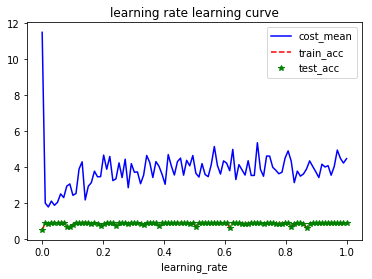

In [107]:
plt.plot(learning_rates, cost_lrning_rates,'b',label = 'cost_mean')
plt.plot(learning_rates, training_accuracys,'r--',label = 'train_acc')
plt.plot(learning_rates, test_accuracys,'g*',label = 'test_acc')
plt.title("learning rate learning curve")
plt.xlabel('learning_rate')
plt.legend()
plt.show()

##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [108]:
iteration_nums = np.arange(1,1000,10)
cost_iteration_nums_rates = []
training_accuracys = []
test_accuracys = []
for i in iteration_nums:
    b = model(X_train, y_train, X_test, y_test, num_iterations = i, learning_rate = 1e-2)
    cost_iteration_nums_rates.append(np.mean(b['cost']))
    training_accuracys.append(b['training_accuracy'])
    test_accuracys.append(b["test_accuracy"]) 
    

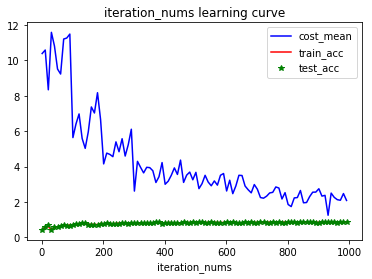

In [109]:
plt.plot(iteration_nums, cost_iteration_nums_rates,'b',label = 'cost_mean')
plt.plot(iteration_nums, training_accuracys,'r-',label = 'train_acc')
plt.plot(iteration_nums, test_accuracys,'g*',label = 'test_acc')
plt.title("iteration_nums learning curve")
plt.xlabel('iteration_nums')
plt.legend()
plt.show()

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digits (0,1,2,3,4,5,6,7,8,9) is in the image.

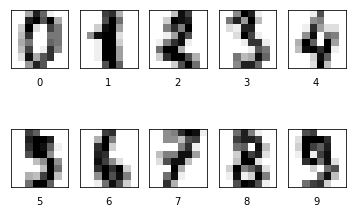

In [144]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np


# Loading the data 
digits = datasets.load_digits()


# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [145]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

# y_train[y_train < 5 ] = 0
# y_train[y_train >= 5] = 1
# y_test[y_test < 5] = 0
# y_test[y_test >= 5] = 1

classes = 10
targets = y_train.reshape(-1)
y_train = np.eye(classes)[targets]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347, 10)
(450,)


In [147]:
def softmax(x):
    """
    Compute the softmax function for each row of the input x.

    Arguments:
    x -- A N dimensional vector or M x N dimensional numpy matrix.

    Return:
    x -- You are allowed to modify x in-place
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        exp_minmax = lambda x: np.exp(x - np.max(x))
        denom = lambda x: 1.0 / np.sum(x)
        x = np.apply_along_axis(exp_minmax,1,x)
        denominator = np.apply_along_axis(denom,1,x) 
        
        if len(denominator.shape) == 1:
            denominator = denominator.reshape((denominator.shape[0],1))
        
        x = x * denominator
    else:
        # Vector
        x_max = np.max(x)
        x = x - x_max
        numerator = np.exp(x)
        denominator =  1.0 / np.sum(numerator)
        x = numerator.dot(denominator)
    
    assert x.shape == orig_shape
    return x


In [149]:
# Random innitialize the parameters

def initialize_parameters(dim_1, dim_2):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    w = np.random.randn(dim_1,dim_2)
#     b = np.random.randn(10).squeeze().tolist()
    b = np.random.randn(dim_2,1)

    assert(w.shape == (dim_1,dim_2))
#     assert(isinstance(b,float) or isinstance(b,int))
    assert(b.shape == (dim_2,1))

    return w,b


In [155]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[0]   ###这里应该把原来的X.shape[1] 改为X.shape[0] 因为这里m表示的是样本量
    A = softmax(np.dot(X, w) + b.T)
    Y = Y.reshape((-1,10))
    cost = (-1./ m) * np.sum(Y*np.log(A.clip(min=0.0000000001)))

    dw = (1./m)*np.dot(X.T , (A-Y)) 
    db = (1./m)*np.sum(A-Y, axis = 0).reshape(b.shape)
    
    assert(dw.shape == w.shape)
#     assert(db.dtype == float)
    assert(db.shape == b.shape)
  
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {'dw':dw,
             'db':db}
    return grads, cost


In [156]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w -= learning_rate * dw
        b -= learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs


In [157]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]   ###这里应该把原来的X.shape[1] 改为X.shape[0]  X的形状是(1347, 64)，其中1347才是代表样本量，因为这里m表示的是样本量
    Y_prediction = np.zeros((m,1))   #####Y_prediction = np.zeros((1,m))改为Y_prediction = np.zeros((m,1)) 与 Y的形状保持一致
    w = w.reshape(X.shape[1],10)   # w所对应的应该是X.shape[1] == 64, 
    b = b.reshape(10,1)

    A = softmax(np.dot(X, w) + b.T)
    #for i in range(A.shape[i]):
        #None    
    ####有更高效的方法替代！！！！
    Y_prediction = np.argmax(A, axis = 1).reshape(m,1)
    
    assert(Y_prediction.shape == (m,1))    #assert(Y_prediction.shape == (1,m))改为assert(Y_prediction.shape == (m, 1))
     
    return Y_prediction


In [158]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost = False):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    w, b = initialize_parameters(X_train.shape[1], Y_train.shape[1])
    
    # grads, cost = propagate(w,b,X_train,Y_train)
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    Y_prediction_train = predict(params['w'], params['b'], X_train)
    Y_prediction_train = Y_prediction_train.astype('int')
    Y_train = np.argmax(Y_train, axis = 1).reshape((-1,1))
    training_accuracy = np.sum(Y_train == Y_prediction_train) / Y_train.shape[0]    

    Y_prediction_test = predict(params['w'], params['b'], X_test)
    Y_prediction_test = Y_prediction_test.astype('int')
    Y_test = Y_test.reshape((-1,1))
    test_accuracy = np.sum(Y_test == Y_prediction_test) / Y_test.shape[0]    
    
    d = {"w":params['w'],
         "b":params['b'],
         "training_accuracy": training_accuracy,
         "test_accuracy" : test_accuracy,
         "cost": costs }
    
    return d


In [159]:
model(X_train, y_train, X_test, y_test, num_iterations = 100, learning_rate = 1e-2, print_cost = True)

Cost after iteration 0: 20.504685


{'w': array([[-3.25045553e-01,  2.89211645e-01,  8.97391883e-01,
          3.41810968e-01,  1.81714892e-01, -9.67357533e-01,
          2.19146224e-01, -9.73234639e-01,  1.43142408e+00,
          8.57964269e-02],
        [ 2.94063501e-01, -1.34758351e+00,  1.27246246e-01,
          2.75663118e-01,  1.73313178e+00, -1.07536437e-01,
          5.21018213e-01, -1.33123374e+00, -1.63587400e+00,
          3.22970905e-01],
        [-2.03782936e-01,  1.39476608e-01, -2.96994452e-02,
          7.71495857e-01,  1.92888130e-01, -1.42832497e+00,
         -2.63891428e-01, -6.69683407e-01, -1.33515787e+00,
          2.40421124e-01],
        [ 8.12463217e-01, -9.32735738e-01,  4.15097612e-02,
          1.54910948e-01, -4.77063150e-01, -4.64210178e-01,
         -3.21763597e-01,  6.94723749e-01,  3.16322061e-01,
          8.29719169e-01],
        [ 3.18990852e-01, -1.36608797e+00,  1.59184868e-01,
         -8.32172640e-01,  7.81209706e-01,  1.34251844e+00,
          8.04284287e-01,  6.90740966e-01,  9.2

In [160]:
model(X_train, y_train, X_test, y_test, num_iterations = 1000, learning_rate = 1e-2, print_cost = True)

Cost after iteration 0: 21.000342
Cost after iteration 100: 9.391338
Cost after iteration 200: 4.414310
Cost after iteration 300: 2.702782
Cost after iteration 400: 2.012494
Cost after iteration 500: 1.552081
Cost after iteration 600: 1.244494
Cost after iteration 700: 1.042644
Cost after iteration 800: 0.885282
Cost after iteration 900: 0.774346


{'w': array([[ 2.02006953e-01,  5.16484560e-01, -6.61570639e-01,
          3.35280425e-01, -1.73534321e-01,  6.12664206e-01,
         -1.29726625e+00,  1.06427066e-01,  3.66866348e-01,
          1.93948676e-01],
        [ 4.08535593e-01,  4.97736396e-01, -2.39547086e+00,
          1.24888654e+00,  6.72216853e-01,  1.31915215e+00,
         -1.29753021e+00,  1.23730553e-02,  1.91909661e+00,
         -1.84169186e+00],
        [-6.40809771e-01,  1.26316556e-01, -4.32583593e-01,
          6.57019089e-01,  3.88122004e-01,  2.47308995e-01,
         -6.20717484e-01,  7.62478353e-01, -3.28064385e-01,
         -1.49571005e+00],
        [-1.03197039e+00, -6.12762555e-01, -4.92269356e-01,
          2.63440674e-01, -1.97630495e+00, -6.23635375e-01,
         -6.97811659e-01,  3.81889851e-01, -3.95632718e-02,
          9.22954754e-01],
        [ 1.10857451e+00, -1.09022658e+00, -1.58106477e-01,
          1.82226564e+00,  1.52987192e-02,  1.77193596e+00,
         -7.03495260e-01, -1.43037697e-01,  4.6

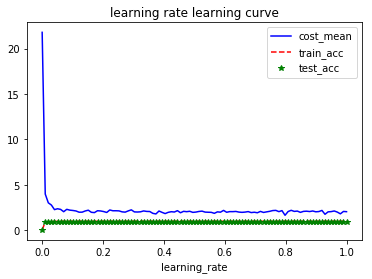

In [161]:
learning_rates = np.linspace(0,1,100)
cost_lrning_rates = []
training_accuracys = []
test_accuracys = []
for i in learning_rates:
    b = model(X_train, y_train, X_test, y_test, num_iterations = 1000, learning_rate = i)
    cost_lrning_rates.append(np.mean(b['cost']))
    training_accuracys.append(b['training_accuracy'])
    test_accuracys.append(b["test_accuracy"]) 
    
    
plt.plot(learning_rates, cost_lrning_rates,'b',label = 'cost_mean')
plt.plot(learning_rates, training_accuracys,'r--',label = 'train_acc')
plt.plot(learning_rates, test_accuracys,'g*',label = 'test_acc')
plt.title("learning rate learning curve")
plt.xlabel('learning_rate')
plt.legend()
plt.show()


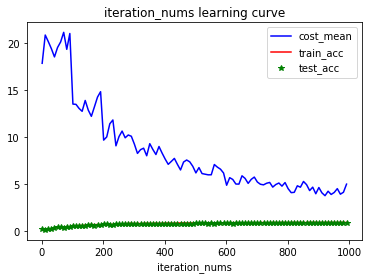

In [163]:
iteration_nums = np.arange(1,1000,10)
cost_iteration_nums_rates = []
training_accuracys = []
test_accuracys = []
for i in iteration_nums:
    b = model(X_train, y_train, X_test, y_test, num_iterations = i, learning_rate = 1e-2)
    cost_iteration_nums_rates.append(np.mean(b['cost']))
    training_accuracys.append(b['training_accuracy'])
    test_accuracys.append(b["test_accuracy"]) 
    
    
plt.plot(iteration_nums, cost_iteration_nums_rates,'b',label = 'cost_mean')
plt.plot(iteration_nums, training_accuracys,'r-',label = 'train_acc')
plt.plot(iteration_nums, test_accuracys,'g*',label = 'test_acc')
plt.title("iteration_nums learning curve")
plt.xlabel('iteration_nums')
plt.legend()
plt.show()


# Congratulations ! You have completed assigment 4. 